<a href="https://colab.research.google.com/github/avaimar/social_cohesion/blob/main/GAN_for_student_level_randomization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Colab Environment

**Note 1: Sometimes the colab notebook runtimes 'break' and you get runtime errors for no reason. In these cases, restart the runtime by clicking 'Runtime' -> 'Restart Runtime' and run everything in this section again.** 

**Note 2: If you care about speed, make sure your colab runtime uses a GPU. Do this by selecting 'Runtime' -> 'Change Runtime Type' -> 'Hardware Accelerator' -> 'GPU' (the runtime will restart and you'll have to re-run this section).** 

We're going to mount your Google Drive first, using the command below. Just follow the prompts.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Next, we're going to change the directory to your drive, and make a folder for the tutorial. If any of these steps has been done before, it will simply be skipped (and throw an error message, which you can ignore).

In [ ]:
%cd ~
%cd /content/drive/My\ Drive/
%mkdir wgan-tutorial
%cd wgan-tutorial 

#eventually put our replication repo here 
#!git clone https://github.com/gsbDBI/ds-wgan/

/root
/content/drive/My Drive
/content/drive/My Drive/wgan-tutorial


Next, install the wgan package written for the project: 

In [ ]:
!pip3 uninstall wgan
!pip3 install git+https://github.com/gsbDBI/ds-wgan.git

  Cloning https://github.com/gsbDBI/ds-wgan.git to /tmp/pip-req-build-pyw3fnfq
  Running command git clone -q https://github.com/gsbDBI/ds-wgan.git /tmp/pip-req-build-pyw3fnfq
  Created wheel for wgan: filename=wgan-0.2-cp37-none-any.whl size=12044 sha256=fc0c7ee5143677d6f1567e2e0343f6e0445057032940999e98d23cd02637816a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xli9mkex/wheels/3a/11/00/ece0eed5e7b5b70a47e0042a54d2470e4fe140182eb66463f6
Successfully built wgan


# Simulating Data

The workflow for every single distribution you want to fit:

0.   Load and prepare the data
1.   Initialize a `wgan.DataWrapper` object, which takes care of handling the data
2.   Initialize `wgan.Specifications` object given the `DataWrapper`, which summarizes hyperparameters, etc.
3.   Initialize `wgan.Generator` & `wgan.Critic` given the `Specifications`
4.   Preprocess the data with the `DataWrapper` object
5.   Train the `Generator` & `Critic` via `wgan.train`
6.   Replace columns in df with simulated data from `Generator` using `DataWrapper.apply_generator` 
7.   If you're interested in them, add the `Critic` outputs to the original and/or the generated df via `DataWrapper.apply_critic`
7.   Explore the data via `compare_dfs` & save the new data.

Since **we're fitting two distributions** (Y on X and t, as well as X on t), we'll have to do all these steps twice. 
To keep the code concise, we will put the two versions of every obejct type into one list respectively. Watch out so you **don't get confused by that**!


## Steps 0-3

First load a data file from our project repo

In [ ]:
import pandas as pd 
import wgan 
import io 
import requests


resp = requests.get(
    'https://raw.github.com/gsbDBI/ds-wgan/master/data/original_data/cps.feather',
    stream=True
)
resp.raw.decode_content = True
mem_fh = io.BytesIO(resp.raw.read())
df = pd.read_feather(mem_fh).drop(["u74","u75"],axis=1)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/final_cohesion.csv')

In [ ]:
print(df2)
real_list = []
for i in range(0,6642):
  real_list.append("real")
df2['source']=real_list
print(df2)

      treatment  ffriend  bfriend  ...  f_csize  b_schoolid  source
0             1        1        1  ...       37           9    real
1             1        1        1  ...       37           9    real
2             1        1        1  ...       37           9    real
3             1        0        1  ...       37           9    real
4             1        1        1  ...       37           9    real
...         ...      ...      ...  ...      ...         ...     ...
6637          0        1        0  ...       40         216    real
6638          0        1        2  ...       40         216    real
6639          0        1        2  ...       40         216    real
6640          0        1        2  ...       40         216    real
6641          0        1        0  ...       40         216    real

[6642 rows x 13 columns]
      treatment  ffriend  bfriend  ...  f_csize  b_schoolid  source
0             1        1        1  ...       37           9    real
1             1       

In [ ]:
df2_balanced = df2.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid"]
continuous_lower_bounds_0 = {"b_schoolsize":0,"f_csize":0,"b_schoolid":0}
categorical_vars_0 = ["ffriend", "bfriend", "male", "refugee","astudent"]
context_vars_0 = ["treatment"]

# Y | X, t
continuous_vars_1 = []
continuous_lower_bounds_1 = {}
categorical_vars_1 = ["ffriend"]
context_vars_1 = ["ageinm", "braven_sd", "beyes_sd", "b_schoolsize","f_csize","b_schoolid","ffriend", "bfriend", "male", "refugee","astudent","treatment"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df2_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df2_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 17, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 2, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


In [ ]:
print(df)

      source    t   age  education  ...  nodegree       re74       re75        re78
0       real  1.0  37.0       11.0  ...       1.0      0.000      0.000   9930.0460
1       real  1.0  22.0        9.0  ...       1.0      0.000      0.000   3595.8940
2       real  1.0  30.0       12.0  ...       0.0      0.000      0.000  24909.4500
3       real  1.0  27.0       11.0  ...       1.0      0.000      0.000   7506.1460
4       real  1.0  33.0        8.0  ...       1.0      0.000      0.000    289.7899
...      ...  ...   ...        ...  ...       ...        ...        ...         ...
16172   real  0.0  22.0       12.0  ...       0.0   3975.352   6801.435   2757.4380
16173   real  0.0  20.0       12.0  ...       0.0   1445.939  11832.240   6895.0720
16174   real  0.0  37.0       12.0  ...       0.0   1733.951   1559.371   4221.8650
16175   real  0.0  47.0        9.0  ...       1.0  16914.350  11384.660  13671.9300
16176   real  0.0  40.0       10.0  ...       1.0  13628.660  13144.550   79

After loading in our data as `df`, we will build from it second dataframe called `df_balanced`, by sampling treated and controls with similar probability from `df`. We will train our WGAN on `df_balanced`, which makes sure the quality of the generated outcomes is similar for both treatment groups.



In [ ]:
df_balanced = df.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["age", "education", "re74", "re75"]
continuous_lower_bounds_0 = {"re74": 0, "re75": 0}
categorical_vars_0 = ["black", "hispanic", "married", "nodegree"]
context_vars_0 = ["t"]

# Y | X, t
continuous_vars_1 = ["re78"]
continuous_lower_bounds_1 = {"re78": 0}
categorical_vars_1 = []
context_vars_1 = ["t", "age", "education", "re74", "re75", "black", "hispanic", "married", "nodegree"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df_balanced, continuous_vars_0, categorical_vars_0, 
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df_balanced, continuous_vars_1, categorical_vars_1, 
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 12, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 1, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 4096, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


## Steps 4 & 5

Next, we train the model. How long this will take depends on the batch_size, the size of your data set and the max_epochs you specified.

You can also abort at any time, the model will keep its parameters at their most recent values during training. You can also resume the training, but this resets the optimizer state which basically means you might as well repeat at Step 3.

In [ ]:
# train X | t
x, context = data_wrappers[0].preprocess(df_balanced)
wgan.train(generators[0], critics[0], x, context, specs[0])

epoch 0 | step 9 | WD_test 0.45 | WD_train 0.18 | sec passed 6 |
epoch 100 | step 809 | WD_test 0.68 | WD_train 0.77 | sec passed 29 |
epoch 200 | step 1609 | WD_test 0.53 | WD_train 0.56 | sec passed 30 |
epoch 300 | step 2409 | WD_test 0.58 | WD_train 0.53 | sec passed 30 |
epoch 400 | step 3209 | WD_test 0.25 | WD_train 0.39 | sec passed 30 |
epoch 500 | step 4009 | WD_test 0.43 | WD_train 0.39 | sec passed 30 |
epoch 600 | step 4809 | WD_test 0.26 | WD_train 0.37 | sec passed 30 |
epoch 700 | step 5609 | WD_test 0.27 | WD_train 0.33 | sec passed 30 |
epoch 800 | step 6409 | WD_test -0.01 | WD_train 0.33 | sec passed 30 |
epoch 900 | step 7209 | WD_test 0.09 | WD_train 0.32 | sec passed 30 |


In [ ]:
x, context = data_wrappers[0].preprocess(df2_balanced)
wgan.train(generators[0], critics[0], x, context, specs[0])

epoch 0 | step 9 | WD_test 0.51 | WD_train 0.17 | sec passed 0 |
epoch 100 | step 809 | WD_test 0.96 | WD_train 1.14 | sec passed 32 |
epoch 200 | step 1609 | WD_test 0.95 | WD_train 1.01 | sec passed 32 |
epoch 300 | step 2409 | WD_test 0.84 | WD_train 0.94 | sec passed 32 |
epoch 400 | step 3209 | WD_test 0.75 | WD_train 0.91 | sec passed 32 |
epoch 500 | step 4009 | WD_test 0.87 | WD_train 0.89 | sec passed 32 |
epoch 600 | step 4809 | WD_test 0.65 | WD_train 0.83 | sec passed 32 |
epoch 700 | step 5609 | WD_test 0.74 | WD_train 0.8 | sec passed 32 |
epoch 800 | step 6409 | WD_test 0.63 | WD_train 0.76 | sec passed 32 |
epoch 900 | step 7209 | WD_test 0.65 | WD_train 0.74 | sec passed 31 |


In [ ]:
# train Y | X, t
x, context = data_wrappers[1].preprocess(df2_balanced)
wgan.train(generators[1], critics[1], x, context, specs[1])

epoch 0 | step 9 | WD_test 0.14 | WD_train 0.05 | sec passed 0 |
epoch 100 | step 809 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 200 | step 1609 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 300 | step 2409 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 400 | step 3209 | WD_test 0.09 | WD_train 0.05 | sec passed 33 |
epoch 500 | step 4009 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 600 | step 4809 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 700 | step 5609 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 800 | step 6409 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |
epoch 900 | step 7209 | WD_test 0.09 | WD_train 0.05 | sec passed 32 |


In [ ]:
# train Y | X, t
x, context = data_wrappers[1].preprocess(df_balanced)
wgan.train(generators[1], critics[1], x, context, specs[1])

epoch 0 | step 9 | WD_test 0.1 | WD_train 0.05 | sec passed 0 |
epoch 100 | step 809 | WD_test -0.12 | WD_train 0.21 | sec passed 30 |
epoch 200 | step 1609 | WD_test 0.14 | WD_train 0.14 | sec passed 30 |
epoch 300 | step 2409 | WD_test -0.0 | WD_train 0.21 | sec passed 30 |
epoch 400 | step 3209 | WD_test 0.1 | WD_train 0.26 | sec passed 30 |
epoch 500 | step 4009 | WD_test 0.05 | WD_train 0.25 | sec passed 30 |
epoch 600 | step 4809 | WD_test 0.0 | WD_train 0.24 | sec passed 30 |
epoch 700 | step 5609 | WD_test 0.16 | WD_train 0.24 | sec passed 30 |
epoch 800 | step 6409 | WD_test 0.05 | WD_train 0.22 | sec passed 30 |
epoch 900 | step 7209 | WD_test 0.27 | WD_train 0.23 | sec passed 30 |


## Steps 6 & 8

In [ ]:
# simulate data with conditional WGANs
df_generated = data_wrappers[0].apply_generator(generators[0], df.sample(int(1e6), replace=True))
df_generated = data_wrappers[1].apply_generator(generators[1], df_generated)


# add counterfactual outcomes
from copy import copy
df_generated_cf = copy(df_generated)
df_generated_cf["t"] = 1 - df_generated_cf["t"] 
df_generated["re78_cf"] = data_wrappers[1].apply_generator(generators[1], df_generated_cf)["re78"]

# save to .feather
#df_generated.to_feather("data/generated/{}_generated.feather".format(name))

In [ ]:
# simulate data with conditional WGANs
df2_generated = data_wrappers[0].apply_generator(generators[0], df2.sample(int(1e6), replace=True))
df2_generated = data_wrappers[1].apply_generator(generators[1], df2_generated)


# add counterfactual outcomes
from copy import copy
df2_generated_cf = copy(df2_generated)
df2_generated_cf["treatment"] = 1 - df2_generated_cf["treatment"] 
df2_generated["ffriend"] = data_wrappers[1].apply_generator(generators[1], df2_generated_cf)["ffriend"]

# save to .feather
#df_generated.to_feather("data/generated/{}_generated.feather".format(name))

In [ ]:
print(df2_generated)

        treatment  ffriend  bfriend  ...    f_csize  b_schoolid  source
0               0      1.0      0.0  ...  18.673122  113.601013    real
1               1      1.0      1.0  ...  35.329136    0.000000    real
2               1      1.0      1.0  ...  23.923531    0.000000    real
3               1      1.0      1.0  ...  34.891190    0.000000    real
4               1      1.0      1.0  ...  34.139519    0.000000    real
...           ...      ...      ...  ...        ...         ...     ...
999995          1      1.0      2.0  ...  34.852070    0.000000    real
999996          1      1.0      1.0  ...  36.877655    0.000000    real
999997          1      1.0      0.0  ...  43.150227  163.199554    real
999998          1      1.0      1.0  ...  22.183723    0.000000    real
999999          1      1.0      1.0  ...  34.021065    0.000000    real

[1000000 rows x 13 columns]


att: -167.4925962867065
-------------comparison of means-------------
t               0.0                1.0         
source         fake      real     fake     real
age           33.87     33.23    26.35    25.82
education     12.28     12.03    10.61    10.35
black          0.08      0.07     0.84     0.84
hispanic       0.07      0.07     0.06     0.06
married        0.71      0.71     0.18     0.19
nodegree       0.29      0.30     0.70     0.71
re74       13579.77  14016.80  1707.26  2095.57
re75       13151.16  13650.80  1111.49  1532.06
re78       14641.72  14846.66  4954.14  6349.14
-------------comparison of stds-------------
t              0.0               1.0         
source        fake     real     fake     real
age          11.17    11.05     7.00     7.16
education     2.84     2.87     1.89     2.01
black         0.27     0.26     0.37     0.36
hispanic      0.25     0.26     0.23     0.24
married       0.45     0.45     0.38     0.39
nodegree      0.46     0.46     0.4

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


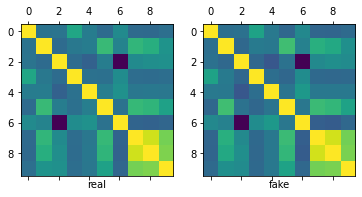

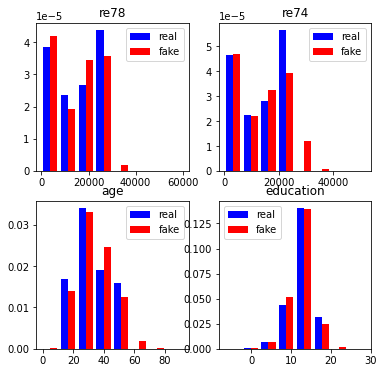

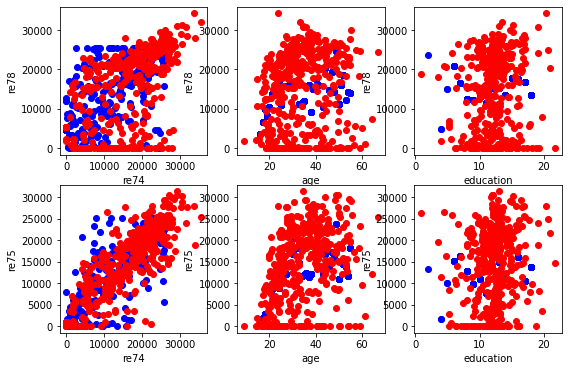

In [ ]:
print("att:", ((df_generated.re78-df_generated.re78_cf) * (2*df_generated.t - 1))[df_generated.t==1].mean())
wgan.compare_dfs(df, df_generated, 
                 scatterplot=dict(x=["re74", "age", "education"], y=["re78", "re75"], samples=400, smooth=0),
                 table_groupby=["t"],
                 histogram=dict(variables=["re78", "re74", "age", "education"], nrow=2, ncol=2),
                 figsize=3)

In [ ]:
print(df_generated)

       source    t        age  ...          re75          re78       re78_cf
0        fake  0.0  34.202232  ...   9142.297852  18534.562500  15300.093750
1        fake  0.0  25.686167  ...      0.000000   2692.714844   5633.085449
2        fake  0.0  47.175728  ...  23439.255859  26306.789062  25620.718750
3        fake  0.0  27.613186  ...      0.000000      0.000000   4613.242676
4        fake  0.0  40.814003  ...   9122.589844  20976.351562  16766.849609
...       ...  ...        ...  ...           ...           ...           ...
999995   fake  0.0  32.908028  ...   9482.129883  19978.039062   4741.452637
999996   fake  0.0  26.356995  ...  19510.714844  16402.160156  10902.927734
999997   fake  0.0  35.689857  ...  25075.433594  29753.554688  29376.910156
999998   fake  0.0  23.850750  ...   7259.390625  15772.792969   3426.900879
999999   fake  0.0  21.209393  ...   4802.629883      0.000000   7653.113770

[1000000 rows x 12 columns]
